In [2]:
import torch
import numpy as np
import random
import torch.nn as nn
import hashlib
import matplotlib.pyplot as plt


In [3]:
def init_random():
    # Set seeds for reproducibility
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(123)
    random.seed(123)



# Define parameters
dim = 768
num_heads = 12
head_dim = dim // num_heads
scale = head_dim ** -0.5
qkv_bias = False
proj_bias = True
attn_drop_rate = 0.1
proj_drop_rate = 0.0

In [4]:
def custom_attn_forward(x: torch.Tensor, scale=scale) -> torch.Tensor:
    B, N, C = x.shape
    qkv_out = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv_out[0] * scale, qkv_out[1], qkv_out[2]

    attn = q @ k.transpose(-2, -1)
    attn = attn.softmax(dim=-1)
    attn = attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = proj(x)
    x = proj_drop(x)
    return x

In [5]:
# Initialize modules with controlled random weights for reproducibility
init_random()
qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
attn_drop = nn.Dropout(attn_drop_rate)
proj = nn.Linear(dim, dim, bias=proj_bias)
proj_drop = nn.Dropout(proj_drop_rate)
x = torch.randn((100, 3, dim))

# Forward pass
out = custom_attn_forward(x)

In [6]:
random_out = torch.randn(out.shape)
torch.dist(out,random_out)

tensor(490.1556, grad_fn=<DistBackward0>)

In [7]:
init_random()
qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
attn_drop = nn.Dropout(attn_drop_rate)
proj = nn.Linear(dim, dim, bias=proj_bias)
proj_drop = nn.Dropout(proj_drop_rate)
x = torch.randn((100, 3, dim))
def custom_attn_forward(x: torch.Tensor, scale=scale) -> torch.Tensor:
    B, N, C = x.shape
    qkv_out = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv_out[0] * scale, qkv_out[1], qkv_out[2]

    attn = q @ k.transpose(-2, -1)
    attn = attn.softmax(dim=-1)
    attn = attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = proj(x)
    x = proj_drop(x)
    return x
out2 = custom_attn_forward(x)
torch.dist(out,out2)

tensor(0., grad_fn=<DistBackward0>)

It's reproducible

In [8]:
init_random()
qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
attn_drop = nn.Dropout(attn_drop_rate)
proj = nn.Linear(dim, dim, bias=proj_bias)
proj_drop = nn.Dropout(proj_drop_rate)
x = torch.randn((100, 3, dim))
def custom_attn_forward(x: torch.Tensor, scale=scale) -> torch.Tensor:
    B, N, C = x.shape
    # Split weights and biases for query, key, value from qkv layer
    Wq, Wk, Wv = qkv.weight.chunk(3, dim=0)
    bq, bk, bv = qkv.bias.chunk(3, dim=0) if qkv.bias is not None else (0, 0, 0)

    # Compute query, key, and value separately
    q = (x @ Wq.T + bq).reshape(B, N, num_heads, C // num_heads).permute(0, 2, 1, 3) * scale
    k = (x @ Wk.T + bk).reshape(B, N, num_heads, C // num_heads).permute(0, 2, 1, 3)
    v = (x @ Wv.T + bv).reshape(B, N, num_heads, C // num_heads).permute(0, 2, 1, 3)
    print(k.shape,q.shape,v.shape)
    attn = q @ k.transpose(-2, -1)
    print(attn.shape)
    attn = attn.softmax(dim=-1)
    attn = attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = proj(x)
    x = proj_drop(x)
    return x
out3 = custom_attn_forward(x)
print(f"Distance to original: {torch.dist(out, out3).item():.3f}")


torch.Size([100, 12, 3, 64]) torch.Size([100, 12, 3, 64]) torch.Size([100, 12, 3, 64])
torch.Size([100, 12, 3, 3])
Distance to original: 0.000


computing k,q,v separately with matrix product works

In [9]:
init_random()
qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
attn_drop = nn.Dropout(attn_drop_rate)
proj = nn.Linear(dim, dim, bias=proj_bias)
proj_drop = nn.Dropout(proj_drop_rate)
C= 3
x = torch.randn((100, C, dim))
def custom_attn_forward(x: torch.Tensor, scale=scale) -> torch.Tensor:
    B, N, C = x.shape
    # Split weights and biases for query, key, value from qkv layer
    Wq, Wk, Wv = qkv.weight.chunk(3, dim=0)
    M = Wq @ Wk.T
    U, S, Vh = torch.linalg.svd(M)
    Wq = U @ torch.diag_embed(S) 
    Wk = Vh.T
    bq, bk, bv = qkv.bias.chunk(3, dim=0) if qkv.bias is not None else (0, 0, 0)
    v = (x @ Wv.T + bv).reshape(B, N, num_heads, dim // num_heads).permute(0, 2, 1, 3)

    print(num_heads,Wq.shape)
    # Reshape weights for multi-head attention
    Wq = Wq.reshape(num_heads,dim,head_dim)*scale
    Wk = Wk.reshape(num_heads, dim,head_dim)

    x_expanded = x.reshape(B, N, num_heads,  head_dim)

    # Main term for attention, reshaped to include heads
    main_term = torch.einsum('bnhd,hde,bmeh->bhnm', x_expanded, Wq.permute(0, 2, 1) @  Wk, x_expanded.transpose(-2, -1))
    print(main_term.shape)

    # First Cross Term: x_expanded @ Wq @ bk
    first_cross_term = torch.einsum('bnhd,hd->bhn', x_expanded, Wq.permute(0, 2, 1) @ bk)
    print(first_cross_term.shape)


    # Second Cross Term: bq @ Wk @ x_expanded.transpose(-2, -1)
    second_cross_term = torch.einsum('hd,bndh->bhn', bq.T @ Wk, x_expanded.transpose(-2, -1))
    print(second_cross_term.shape)

    # Constant Bias Term: bq @ bk
    constant_bias_term = bq.T @ bk 
    print(constant_bias_term.shape)

    # Full expanded formula for attention scores
    attn = main_term + first_cross_term.unsqueeze(-1) + second_cross_term.unsqueeze(-1)  + constant_bias_term

    attn = attn.softmax(dim=-1)
    attn = attn_drop(attn)

    attn = attn.softmax(dim=-1)
    attn = attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = proj(x)
    x = proj_drop(x)
    return x
out3 = custom_attn_forward(x)
print(f"Distance to original: {torch.dist(out, out3).item():.3f}")

12 torch.Size([768, 768])
torch.Size([100, 12, 3, 3])


TypeError: unsupported operand type(s) for @: 'Tensor' and 'int'

In [ ]:
Q_linear = torch.nn.Linear(dim,dim, bias=False)
init_random()
qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
attn_drop = nn.Dropout(attn_drop_rate)
proj = nn.Linear(dim, dim, bias=proj_bias)
proj_drop = nn.Dropout(proj_drop_rate)
C= 3
x = torch.randn((100, C, dim))
def custom_attn_forward(x: torch.Tensor, scale=scale, rank=head_dim) -> torch.Tensor:
    B, N, C = x.shape
    # Split weights and biases for query, key, value from qkv layer
    print(x.shape)
    Wqkv = qkv.weight.chunk(3, dim=0)
    Wq, Wk, Wv = Wqkv[0], Wqkv[1], Wqkv[2]  # Separate out Wq, Wk, and Wv
    print(Wq.shape)


    #M = torch.bmm(Wq.T, Wk)
    #M = Wq.T @ Wk
    #U, S, Vh = torch.linalg.svd(M,full_matrices=True)
    #diagonal_scale = torch.cat([torch.ones(rank), torch.zeros(dim - rank)])
    #S = S * diagonal_scale.unsqueeze(0)
    #Wq = torch.bmm(U[:,:,:head_dim],  torch.diag_embed(S[:,:head_dim]))
    #print(torch.diag(S[:head_dim]).shape)
    #Wq = U[:,:head_dim] @  torch.diag(S[:head_dim])
    #Wk = Vh[:,:head_dim]    # Compute query, key, and value separately
    #Wq = U @  torch.diag(S)
    #Wk = Vh


    print('can I recompute the weights?')
    print(torch.equal(qkv.weight.data , torch.cat([Wq, Wk, Wv], dim=0)))


    #qkv.weight = nn.Parameter(torch.cat([Wq, Wk, Wv], dim=0))

    qkv_out = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv_out[0] *scale , qkv_out[1], qkv_out[2]
    q2 = scale *(x @ Wq.T).reshape(B, N, num_heads, C // num_heads).permute(0, 2, 1, 3)
    k2 =  (x @ Wk.T).reshape(B, N, num_heads, C // num_heads).permute(0, 2, 1, 3)
    attn2 =  q2 @ k2.transpose(-2, -1)

    print(attn2.shape, q2.shape, k2.transpose(-2, -1).shape)


    attn = q @ k.transpose(-2, -1)
    print('can I recompute Q,K and the attention? (no head reshaping)')
    print(torch.equal(q , q2),torch.equal(k , k2),torch.equal(attn , attn2))#.permute(2, 0, 3, 1, 4)))

    attn = attn.softmax(dim=-1)
    attn = attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = proj(x)
    x = proj_drop(x)
    return x


out3 = custom_attn_forward(x,rank=12)
print(f"Distance to original: {torch.dist(out, out3).item()}")

torch.Size([100, 3, 768])
torch.Size([768, 768])
can I recompute the weights?
True
torch.Size([100, 12, 3, 3]) torch.Size([100, 12, 3, 64]) torch.Size([100, 12, 64, 3])
can I recompute Q,K and the attention? (no head reshaping)
True True True
Distance to original: 0.0


In [ ]:
Q_linear = torch.nn.Linear(dim,dim, bias=False)
init_random()
qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
attn_drop = nn.Dropout(attn_drop_rate)
proj = nn.Linear(dim, dim, bias=proj_bias)
proj_drop = nn.Dropout(proj_drop_rate)
C= 3
x = torch.randn((100, C, dim))
def custom_attn_forward(x: torch.Tensor, scale=scale, rank=head_dim) -> torch.Tensor:
    B, N, C = x.shape
    # Split weights and biases for query, key, value from qkv layer
    print(x.shape)
    Wqkv = qkv.weight.chunk(3, dim=0)
    Wq, Wk, Wv = Wqkv[0], Wqkv[1], Wqkv[2]  # Separate out Wq, Wk, and Wv
    print(Wq.shape)


    #M = torch.bmm(Wq.T, Wk)
    #M = Wq.T @ Wk
    #U, S, Vh = torch.linalg.svd(M,full_matrices=True)
    #diagonal_scale = torch.cat([torch.ones(rank), torch.zeros(dim - rank)])
    #S = S * diagonal_scale.unsqueeze(0)
    #Wq = torch.bmm(U[:,:,:head_dim],  torch.diag_embed(S[:,:head_dim]))
    #print(torch.diag(S[:head_dim]).shape)
    #Wq = U[:,:head_dim] @  torch.diag(S[:head_dim])
    #Wk = Vh[:,:head_dim]    # Compute query, key, and value separately
    #Wq = U @  torch.diag(S)
    #Wk = Vh


    print('can I recompute the weights?')
    print(torch.equal(qkv.weight.data , torch.cat([Wq, Wk, Wv], dim=0)))


    #qkv.weight = nn.Parameter(torch.cat([Wq, Wk, Wv], dim=0))

    qkv_out = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv_out[0] *scale , qkv_out[1], qkv_out[2]
    q2 = scale *(x @ Wq.T).reshape(B, N, num_heads, C // num_heads).permute(0, 2, 1, 3)
    k2 =  (x @ Wk.T).reshape(B, N, num_heads, C // num_heads).permute(0, 2, 1, 3)
    attn2 =  q2 @ k2.transpose(-2, -1)

    print(attn2.shape, q2.shape, k2.transpose(-2, -1).shape)

    #Wq_heads = Wq.reshape(num_heads, head_dim, -1)  # [12, 64, 768]
    #q3 = (x.unsqueeze(1) @ Wq_heads.permute(0, 2, 1))

    #Wq_heads = Wq.reshape(num_heads,-1, head_dim)  # [12,768, 64]
    #q3 = (x.unsqueeze(1) @ Wq_heads)

    #Wq_heads = Wq.reshape(-1,num_heads, head_dim)  # [768,12, 64]
    #q3 = (x.unsqueeze(1) @ Wq_heads.permute(1, 0, 2))

    #Wq_heads = Wq.reshape(-1,num_heads, head_dim)  # [768,12, 64]
    #q3 = (x.unsqueeze(1) @ Wq_heads.permute(1, 0, 2))

    Wq_heads = Wq.chunk(num_heads, dim=0)
    print(Wq_heads)
    print("ok",Wq_heads[0].shape)
    print((Wq_heads[0].T).shape)
    q_chunks = [(x @ Wq_head.T).unsqueeze(1) for Wq_head in Wq_heads]  # List of [B, 1, C, head_dim] tensors

    q3 = torch.cat(q_chunks, dim=1)



    print(q3.shape)
    print(q.shape, q3.shape)
    print(torch.equal(q , q3))

    attn = q @ k.transpose(-2, -1)
    print('can I recompute Q,K and the attention? (no head reshaping)')
    print(torch.equal(q , q2),torch.equal(k , k2),torch.equal(attn , attn2))#.permute(2, 0, 3, 1, 4)))

    attn = attn.softmax(dim=-1)
    attn = attn_drop(attn)

    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = proj(x)
    x = proj_drop(x)
    return x


out3 = custom_attn_forward(x,rank=12)
print(f"Distance to original: {torch.dist(out, out3).item()}")

torch.Size([100, 3, 768])
torch.Size([768, 768])
can I recompute the weights?
True
torch.Size([100, 12, 3, 3]) torch.Size([100, 12, 3, 64]) torch.Size([100, 12, 64, 3])


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
C = 5
x = torch.randn((100, C, dim))

qkv = nn.Linear(dim, dim * 3, bias=False)
wq =  qkv.weight.chunk(3, dim=0)[0]
qkv_out = qkv(x)
y = x @ wq.T
print(torch.equal(qkv_out.chunk(3, dim=2)[0],y))

True


In [ ]:
import torch

# Example tensor
A = torch.randn(9, 4)  # Example tensor with shape (9, 4)

# Split into 3 chunks along dimension 0
B = A.chunk(3, dim=0)

# Concatenate the chunks back along dimension 0
A_reconstructed = torch.cat(B, dim=0)

# Verify if A and A_reconstructed are the same
print(torch.allclose(A, A_reconstructed))  # Should print: True
print(A_reconstructed)  # Prints the reconstructed tensor


True
tensor([[-1.3161, -1.7805,  1.2773,  1.0039],
        [ 1.6497,  1.6137,  2.3427, -0.1695],
        [ 0.8789, -1.3289, -0.5491,  0.0449],
        [ 3.4008,  0.7467, -0.4544,  2.0355],
        [-2.2082, -1.0199, -0.6361, -1.1402],
        [-2.7425, -1.4518,  1.0103, -0.2906],
        [ 0.5358, -0.1602,  1.3215, -0.7169],
        [ 0.3738, -1.8019,  0.2151, -1.1909],
        [ 0.8262, -0.1136, -1.3393, -0.3467]])


In [ ]:
import torch

# Define a random tensor with shape [768, 768]
Wq = torch.rand(768, 768)

# Define parameters for heads
num_heads = 12
head_dim = 768 // num_heads


# Step 1: Reshape Wq
Wq_reshaped = Wq.reshape(num_heads, head_dim, 768)  # Shape: [12, 64, 768]

# Step 2: Chunk Wq along the first dimension into num_heads chunks
Wq_chunks = Wq.chunk(num_heads, dim=0)  # List of 12 tensors, each with shape [64, 768]

# Step 3: Concatenate the chunks to match the shape of the reshaped tensor
Wq_chunked_concat = torch.stack(Wq_chunks)  # Shape: [12, 64, 768]

# Step 4: Check for equality
equal_check = torch.equal(Wq_reshaped, Wq_chunked_concat)
print("Are Wq_reshaped and Wq_chunked_concat equal?", equal_check)


Are Wq_reshaped and Wq_chunked_concat equal? True


In [ ]:
import torch

# Define a random tensor with shape [768, 768]
Wq = torch.rand(768, 768)
x = torch.rand(1, 768)

# Define parameters for heads
num_heads = 12
head_dim = 768 // num_heads

y_reshaped = x @ Wq.T
y_reshaped = y_reshaped.reshape(num_heads, head_dim)
print(y_reshaped.shape)


# Step 1: Reshape Wq
Wq_reshaped = Wq.reshape(num_heads, head_dim, 768)  # Shape: [12, 64, 768]
y2 = x @ Wq_reshaped.permute(0,2,1)
y2 = y2.reshape(num_heads, head_dim)

print(y2.shape)
print(torch.equal(y_reshaped,y2))

# Step 2: Chunk Wq along the first dimension into num_heads chunks
Wq_chunks = Wq.chunk(num_heads, dim=0)  # List of 12 tensors, each with shape [64, 768]

# Step 3: Concatenate the chunks to match the shape of the reshaped tensor
Wq_chunked_concat = torch.stack(Wq_chunks)  # Shape: [12, 64, 768]

# Step 4: Check for equality
equal_check = torch.equal(Wq_reshaped, Wq_chunked_concat)
print("Are Wq_reshaped and Wq_chunked_concat equal?", equal_check)


torch.Size([12, 64])
torch.Size([12, 64])
True
Are Wq_reshaped and Wq_chunked_concat equal? True


In [ ]:
import torch


B=100
C = 5
# Define a random tensor with shape [768, 768]
Wq = torch.rand(768, 768)
x = torch.rand(1, 768)

# Define parameters for heads
num_heads = 12
head_dim = 768 // num_heads

y_reshaped = x @ Wq.T
y_reshaped = y_reshaped.reshape(num_heads, head_dim)
print(y_reshaped.shape)


# Step 1: Reshape Wq
Wq_reshaped = Wq.reshape(num_heads, head_dim, 768)  # Shape: [12, 64, 768]
y2 = x @ Wq_reshaped.permute(0,2,1)
y2 = y2.reshape(num_heads, head_dim)

print(y2.shape)
print(torch.equal(y_reshaped,y2))


torch.Size([12, 64])
torch.Size([12, 64])
True


In [ ]:
import torch


B=100
C = 5
# Define a random tensor with shape [768, 768]
Wq = torch.rand(768, 768)
x = torch.rand(B,C, 768)

# Define parameters for heads
num_heads = 12
head_dim = 768 // num_heads

y_reshaped = x @ Wq.T
y_reshaped = y_reshaped.reshape(B,C,num_heads, head_dim)
print(y_reshaped.shape)


# Step 1: Reshape Wq
Wq_reshaped = Wq.reshape(num_heads, head_dim, 768)  # Shape: [12, 64, 768]
print(x.unsqueeze(-2).shape)
print(Wq_reshaped.permute(0,2,1).shape)
y2 = x.unsqueeze(-2)@ Wq_reshaped.permute(0,2,1)
y2 = y2.reshape(B,C,num_heads, head_dim)

print(y2.shape)
print(torch.equal(y_reshaped,y2))


torch.Size([100, 5, 12, 64])
torch.Size([100, 5, 1, 768])
torch.Size([12, 768, 64])


RuntimeError: The size of tensor a (5) must match the size of tensor b (12) at non-singleton dimension 1

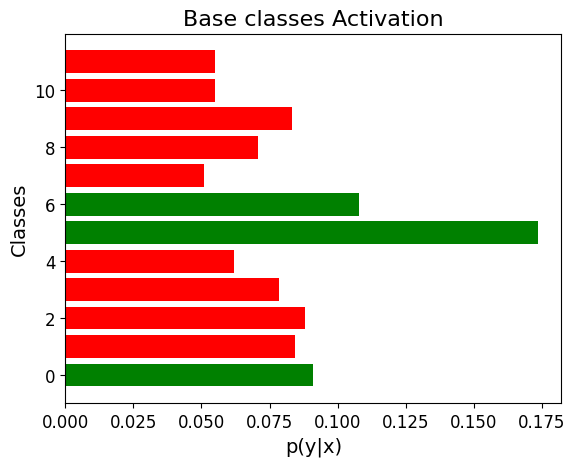

In [ ]:
import torch
import matplotlib.pyplot as plt

# Define parameters and generate data
N = 12
a = torch.randn(N)
b = torch.softmax(a / 2, dim=0)
x = torch.arange(N)

# Sort the indices of b to find the top 3 values
top3_indices = torch.topk(b, 3).indices

# Set colors: red for top 3, default color for others
colors = ['green' if i in top3_indices else 'red' for i in range(N)]

# Create horizontal bar chart with specified colors
plt.barh(x, b, color=colors)
plt.xlabel('p(y|x)', fontsize=14)
plt.ylabel('Classes', fontsize=14)
plt.title('Base classes Activation', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [ ]:
a = 173+39

a/2

106.0

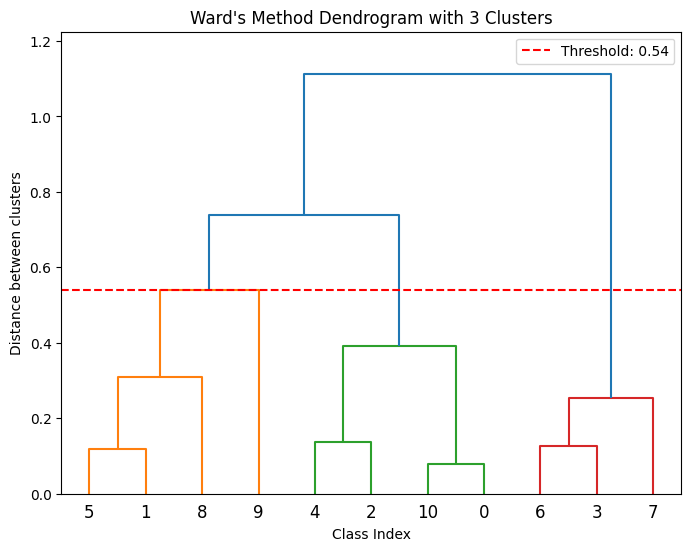

Sample 1 is in cluster 2
Sample 2 is in cluster 3
Sample 3 is in cluster 2
Sample 4 is in cluster 1
Sample 5 is in cluster 2
Sample 6 is in cluster 3
Sample 7 is in cluster 1
Sample 8 is in cluster 1
Sample 9 is in cluster 3
Sample 10 is in cluster 3
Sample 11 is in cluster 2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Generate random data (10 samples with 2 features)
np.random.seed(2)
data = np.random.rand(11, 2)

# Perform hierarchical clustering using Ward's method
linked = linkage(data, method='ward')
threshold = linked[-2, 2] #+ 1e-9  # Use the third last distance to set 3 clusters

# Plot dendrogram
plt.figure(figsize=(8, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, color_threshold=threshold)

# Determine threshold distance
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.legend()

# Generate clusters
clusters = fcluster(linked, threshold, criterion='distance')

# Display the results
plt.title("Ward's Method Dendrogram with 3 Clusters")
plt.xlabel("Class Index")
plt.ylabel("Distance between clusters")
plt.ylim(0, max(linked[:, 2]) * 1.1)  # Adjust y-axis to fit the threshold line
plt.show()

# Print clusters
for i, cluster in enumerate(clusters, start=1):
    print(f"Sample {i} is in cluster {cluster}")
